# Copyright 2022 Sang Wook KIm

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Data source (Steam Store Games): https://www.kaggle.com/nikdavis/steam-store-games?select=steam_media_data.csv
#### 

In [1]:
# Import relevant modules
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
print("Imported modules.")

Imported modules.


# Read data

In [2]:
df_steam = pd.read_csv("./database/Steam/steam.csv")
df_steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [3]:
# Name of columns
for col in df_steam.columns:
    print(col, end=' | ')

appid | name | release_date | english | developer | publisher | platforms | required_age | categories | genres | steamspy_tags | achievements | positive_ratings | negative_ratings | average_playtime | median_playtime | owners | price | 

In [4]:
# Drop id and name
df_steam = df_steam.drop(labels =['appid','name'], axis = 1)
# Short statistics
df_steam.describe()

,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000
mean,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193
std,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.690000
50%,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,3.990000
75%,1.000000,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,7.190000
max,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,421.990000


# 1. Insights and data preperation
## label : bucketized number of owners
## features
highly informative: 'categories', 'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'price'

less informative: 'english', 'platforms', 'required_age','achievements'

bias risk: 'release_date', 'developer', 'publisher'

## questions:

1. "Is the release_date related to # of owners?"

2. "Does developer or publisher independently affect # of owners?" - Credit? PR?

3. What features should be used for training?

In [5]:
# transform label representation
  # upper bound for each bucket
df_owners = df_steam['owners'].apply(lambda x: int(x.split('-')[1])//1000)
print(" The number of owner is # K or less")
lookup_list = sorted(list(df_owners.unique()))
print(lookup_list)

 The number of owner is # K or less
[20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]


## To answer the first question, let's find the mean value of the dates
("Does the release_date has strong correlation with # of owners?")

In [6]:
from datetime import datetime

In [7]:
series_date = df_steam.release_date.apply(lambda x: datetime.fromisoformat(x).timestamp())
question1 = pd.concat(
    [df_owners,series_date],
    axis = 1,)

In [8]:
# Days since the game relasesd
array_days = datetime.fromisoformat('2019-05-01').timestamp() - np.array(series_date)
array_days /= (60*60*24)
array_days.min()

0.0

In [9]:
mean_date = question1.groupby('owners').mean()
mean_date['release_date_format'] = mean_date.release_date.apply(
    lambda x: datetime.fromtimestamp(int(x)).isoformat()
    )
mean_date['counts'] = question1.groupby('owners').count()
print("Mean release date")
mean_date

Mean release date


,release_date,release_date_format,counts
owners,,,
20,1.505201e+09,2017-09-12T03:23:00,18596
50,1.457225e+09,2016-03-05T19:40:01,3059
100,1.444877e+09,2015-10-14T22:45:07,1695
200,1.432374e+09,2015-05-23T05:36:47,1386
500,1.414970e+09,2014-11-02T18:18:37,1272
1000,1.392958e+09,2014-02-20T23:51:06,513
2000,1.382017e+09,2013-10-17T09:29:10,288
5000,1.379642e+09,2013-09-19T21:57:49,193
10000,1.325347e+09,2011-12-31T10:50:52,46


<AxesSubplot:>

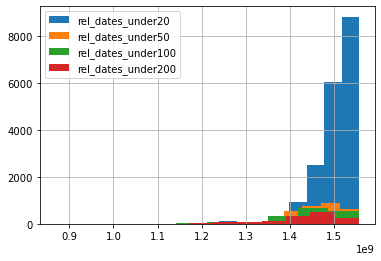

In [10]:
from matplotlib import pyplot as plt
group_date = question1.groupby('owners')
group_date.get_group(20)['release_date'].rename('rel_dates_under20').hist(legend = True)
group_date.get_group(50)['release_date'].rename('rel_dates_under50').hist(legend = True)
group_date.get_group(100)['release_date'].rename('rel_dates_under100').hist(legend = True)
group_date.get_group(200)['release_date'].rename('rel_dates_under200').hist(legend = True)

# Conclusion for Q1:
## The more owners, the older the average release date.

# 2. Data preperation

## In the previous section, we found there are not many games with >10000K owners
## Our label then can be either numeric or categorical as following

In [11]:
  # 1. log of upper bound
df_owners_log = df_owners.apply( lambda x: np.log(x)/2 if x <= 2000 else np.log(5000)/2 )
print(" The number of owner in log scale is # or less")
print(sorted(list(df_owners_log.unique())),"\n")
  # 2. bucket label
df_owners_buckets = df_owners.apply(
        lambda x: str(lookup_list.index(x)+1) if x <= 2000 else '8' )
print(" The level of owners_bucket is:")
print(sorted( [int(x) for x in df_owners_buckets.unique()] ))

 The number of owner in log scale is # or less
[1.4978661367769954, 1.956011502714073, 2.302585092994046, 2.649158683274018, 3.1073040492110957, 3.4538776394910684, 3.800451229771041, 4.258596595708119] 

 The level of owners_bucket is:
[1, 2, 3, 4, 5, 6, 7, 8]


# Features

## Categorical features
### The number of unique values

In [12]:
def n_unique(series):
    return len(series.unique())

In [13]:
print('developer: '+str(n_unique(df_steam['developer'])),
      'publisher: '+str(n_unique(df_steam['publisher'])),
      'platforms: '+str(n_unique(df_steam['platforms'])),
      'required_age: '+str(n_unique(df_steam['required_age'])),
      'categories: '+str(n_unique(df_steam['categories'])),
      'genres: '+str(n_unique(df_steam['genres'])), sep='\n'
     )

developer: 17113
publisher: 14354
platforms: 7
required_age: 6
categories: 3333
genres: 1552


### There are too many developers and publishers. Useful features might be platforms, required_age, and genres

### By looking at 'genres' data, those are not independent features. They are combination of some genres.
### One of the strategy is to set genre lookup table

In [14]:
def semicolon_spliter(x):
    return np.array(x.split(';'))

def voca_list(series):
    voca = []
    for items in series:
        for item in items:
            if item not in voca:
                voca.append(item)
    return voca

In [15]:
split_platforms = df_steam['platforms'].apply(semicolon_spliter)
split_genres = df_steam['genres'].apply(semicolon_spliter)
list_platforms = voca_list(split_platforms)
list_genres = voca_list(split_genres)
print("platforms:", list_platforms)
print("genres:", list_genres)

platforms: ['windows', 'mac', 'linux']
genres: ['Action', 'Free to Play', 'Strategy', 'Adventure', 'Indie', 'RPG', 'Animation & Modeling', 'Video Production', 'Casual', 'Simulation', 'Racing', 'Violent', 'Massively Multiplayer', 'Nudity', 'Sports', 'Early Access', 'Gore', 'Utilities', 'Design & Illustration', 'Web Publishing', 'Education', 'Software Training', 'Sexual Content', 'Audio Production', 'Game Development', 'Photo Editing', 'Accounting', 'Documentary', 'Tutorial']


### Let's break down platforms into three different labels: windows and more, only windows, and else

In [16]:
def platforms_code(x):
    if 'windows' in x:
        if len(x) > 1:
            return 'w+'
        else:
            return 'onlywin'
    else:
        return 'else'
col_platforms = split_platforms.apply(platforms_code)

<AxesSubplot:>

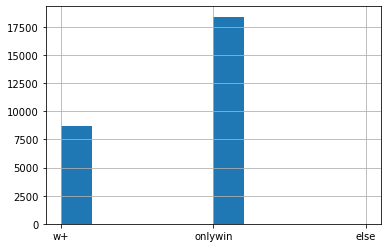

In [17]:
col_platforms.hist()

### For genres, let's combine some minor genres and prioritize majors.

In [18]:
def genre_code(x):
    majors = ['Action', 'Adventure', 'RPG', 'Strategy', 'Simulation', 'Indie']
    code_name = ''
    idxs = []
    for g in x:
        if g in majors:
            idxs.append(majors.index(g))
    if len(idxs) > 0:
        idxs = sorted(idxs)
        for i in idxs:
            code_name += chr(97+i)
        return code_name
    else:
        return 'else'
col_genres = split_genres.apply(genre_code)

<AxesSubplot:>

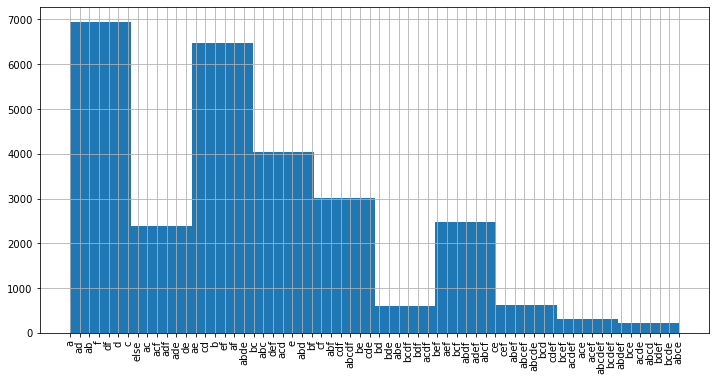

In [19]:
col_genres.hist(xrot=90, figsize = (12,6))

### The 'required_age' feature is dominat by zeros. Code it as zero or not.

In [20]:
col_age = df_steam['required_age'].apply(lambda x: 'yes' if x > 0 else 'no')

<AxesSubplot:>

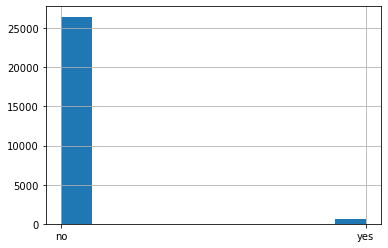

In [21]:
col_age.hist()

#### Still, it's extremely unbalanced feature.

# Numeric features

In [22]:
df_steam[['price','positive_ratings','negative_ratings']].describe()

,price,positive_ratings,negative_ratings
count,27075.000000,2.707500e+04,27075.000000
mean,6.078193,1.000559e+03,211.027147
std,7.874922,1.898872e+04,4284.938531
min,0.000000,0.000000e+00,0.000000
25%,1.690000,6.000000e+00,2.000000
50%,3.990000,2.400000e+01,9.000000
75%,7.190000,1.260000e+02,42.000000
max,421.990000,2.644404e+06,487076.000000


### price: abnormal value exist
### ratings: needs to be normalized

In [23]:
vfunc = np.vectorize(lambda x : 1/(1 + np.exp(-x)))
import scipy.stats as stats

array_price = vfunc(stats.zscore(df_steam['price']))
series_price = pd.Series(data=array_price, name='price', dtype=float,)

<AxesSubplot:>

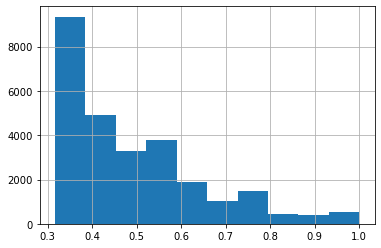

In [24]:
series_price.hist()

In [25]:
def log_chopper(x, bound = 10000):
    if x <= 1:
        return 0
    elif x <= bound:
        return np.log(x)
    else:
        return np.log(bound)

# log_price = df_steam['price'].apply( log_chopper )
# log_price.hist()

<AxesSubplot:>

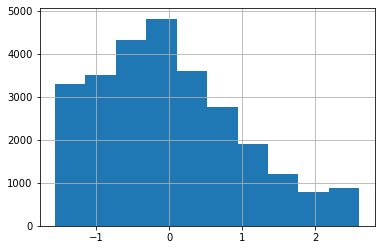

In [26]:
log_p_rate = df_steam['positive_ratings'].apply( log_chopper )

array_pr = stats.zscore(log_p_rate)
series_pr = pd.Series(data=array_pr, name='positive_ratings', dtype=float,)

series_pr.hist()

<AxesSubplot:>

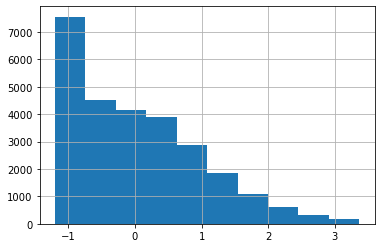

In [27]:
log_n_rate = df_steam['negative_ratings'].apply( log_chopper )
array_nr = stats.zscore(log_n_rate)
series_nr = pd.Series(data=array_nr, name='negative_ratings', dtype=float,)
series_nr.hist()

<AxesSubplot:>

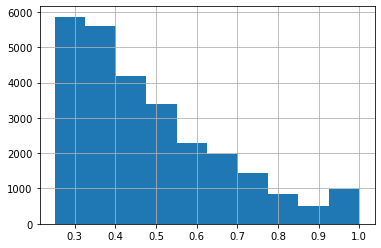

In [28]:
series_days = vfunc(stats.zscore(array_days))
series_days = pd.Series(data=series_days, name='days', dtype=float,)
series_days.hist()

### Combine all

In [29]:
df_reg = pd.concat(
    [series_price, series_pr, series_nr, series_days, col_platforms , col_genres, df_owners_log],
    axis = 1)
df_mclass = pd.concat(
    [series_price, series_pr, series_nr, series_days, col_platforms , col_genres, df_owners_buckets],
    axis = 1)

# only tiny part of data have platforms == 'else'. Let's drop them.
df_reg = df_reg[(df_reg['platforms'] != 'else')]
df_mclass = df_mclass[(df_mclass['platforms'] != 'else')]

# Build model

## 1. Regression model

In [30]:
TARGET = df_reg

In [31]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(TARGET, test_size=0.1)
train, val = train_test_split(train, test_size=0.2)
print(
    "We have %d samples for training, %d for validation, and %d for test"
    % (len(train), len(val), len(test))
)

We have 19490 samples for training, 4873 for validation, and 2707 for test


In [32]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("owners")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)

In [33]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [34]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [35]:
print(train.columns)
print(len(train.columns))

Index(['price', 'positive_ratings', 'negative_ratings', 'days', 'platforms',
       'genres', 'owners'],
      dtype='object')
7


In [36]:
# Categorical features encoded as integers
platforms = keras.Input(shape=(1,), name="platforms", dtype="string")
genres = keras.Input(shape=(1,), name="genres", dtype="string")

# Numerical features
price = keras.Input(shape=(1,), name="price")
positive_ratings = keras.Input(shape=(1,), name="positive_ratings")
negative_ratings = keras.Input(shape=(1,), name="negative_ratings")
days = keras.Input(shape=(1,), name="days")


all_inputs = [
    platforms,
    genres,
    price,
    days,
    positive_ratings,
    negative_ratings,
]

# Integer categorical features
platforms_encoded = encode_categorical_feature(platforms, "platforms", train_ds, True)

# String categorical features
genres_encoded = encode_categorical_feature(genres, "genres", train_ds, True)

# Numerical features
price_encoded = encode_numerical_feature(price, "price", train_ds)
positive_ratings_encoded = encode_numerical_feature(positive_ratings, "positive_ratings", train_ds)
negative_ratings_encoded = encode_numerical_feature(negative_ratings, "negative_ratings", train_ds)
days_encoded = encode_numerical_feature(days, "days", train_ds)


all_features = layers.concatenate(
    [
        platforms_encoded,
    genres_encoded,
    price_encoded,
    days_encoded,
    positive_ratings_encoded,
    negative_ratings_encoded,
    ]
)

In [37]:
# Categorical features encoded as integers
platforms = keras.Input(shape=(1,), name="platforms", dtype="string")
genres = keras.Input(shape=(1,), name="genres", dtype="string")

# Numerical features
price = keras.Input(shape=(1,), name="price")
positive_ratings = keras.Input(shape=(1,), name="positive_ratings")
negative_ratings = keras.Input(shape=(1,), name="negative_ratings")
days = keras.Input(shape=(1,), name="days")


all_inputs = [
    platforms,
    genres,
    price,
    days,
    positive_ratings,
    negative_ratings,
]

# Integer categorical features
platforms_encoded = encode_categorical_feature(platforms, "platforms", train_ds, True)

# String categorical features
genres_encoded = encode_categorical_feature(genres, "genres", train_ds, True)

# Numerical features
price_encoded = encode_numerical_feature(price, "price", train_ds)
positive_ratings_encoded = encode_numerical_feature(positive_ratings, "positive_ratings", train_ds)
negative_ratings_encoded = encode_numerical_feature(negative_ratings, "negative_ratings", train_ds)
days_encoded = encode_numerical_feature(days, "days", train_ds)


all_features = layers.concatenate(
    [
        platforms_encoded,
    genres_encoded,
    price_encoded,
    days_encoded,
    positive_ratings_encoded,
    negative_ratings_encoded,
    ]
)

In [38]:
all_features

<KerasTensor: shape=(None, 72) dtype=float32 (created by layer 'concatenate_1')>

In [39]:
x = None
x = layers.Dense(16, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(8, activation="leaky_relu")(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1)(x)
model = None
model = keras.Model(all_inputs, output)

In [40]:
LEARNING_RATE = 0.001 #@param
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),  
              loss="mean_squared_error",
              metrics=[tf.keras.metrics.MeanSquaredError()]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 platforms (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 genres (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 price (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 days (InputLayer)              [(None, 1)]          0           []                               
                                                                                              

In [41]:
# keras.utils.plot_model(model, show_shapes=True)

In [42]:
history = model.fit(train_ds, epochs=30,
                    validation_data=val_ds)
 
# To track the progression of training, gather a snapshot
# of the model's metrics at each epoch. 
epochs = history.epoch
hist = pd.DataFrame(history.history)

Epoch 1/30
610/610 [==============================] - 1s 988us/step - loss: 0.8805 - mean_squared_error: 0.8805 - val_loss: 0.0782 - val_mean_squared_error: 0.0782
Epoch 2/30
610/610 [==============================] - 1s 876us/step - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.0675 - val_mean_squared_error: 0.0675
Epoch 3/30
610/610 [==============================] - 1s 827us/step - loss: 0.1794 - mean_squared_error: 0.1794 - val_loss: 0.0681 - val_mean_squared_error: 0.0681
Epoch 4/30
610/610 [==============================] - 1s 843us/step - loss: 0.1453 - mean_squared_error: 0.1453 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 5/30
610/610 [==============================] - 1s 857us/step - loss: 0.1262 - mean_squared_error: 0.1262 - val_loss: 0.0594 - val_mean_squared_error: 0.0594
Epoch 6/30
610/610 [==============================] - 1s 847us/step - loss: 0.1133 - mean_squared_error: 0.1133 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 7/30
610/6

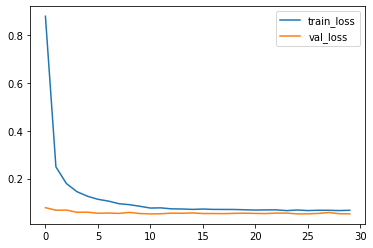

In [43]:
plt.plot(epochs, hist['loss'], label = 'train_loss')
plt.plot(epochs, hist['val_loss'], label = 'val_loss')
plt.legend()

In [44]:
# Evaluate the model on the test data using `evaluate`
test_ds = dataframe_to_dataset(test)
test_ds = test_ds.batch(10)

print("Evaluate on test data")
results = model.evaluate(test_ds)
print("test loss, test mean_squared_error:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
predictions = model.predict(test_ds)
print("predictions shape:", predictions.shape)

Evaluate on test data
271/271 [==============================] - 0s 544us/step - loss: 0.0528 - mean_squared_error: 0.0528
test loss, test mean_squared_error: [0.052824173122644424, 0.052824173122644424]
Generate predictions for test samples
predictions shape: (2707, 1)


In [49]:
# Show random 20 predictions
print("label          predicted")
print("value          value")
print("in original   in original")
print("--------------------------------------")

for i in range(20):
    rand_i = np.random.randint(len(predictions))
    print ("%f      %f" % (test['owners'].iloc[rand_i], predictions[rand_i] ))

label          predicted
value          value
in original   in original
--------------------------------------
1.497866      1.539184
1.497866      1.511131
2.302585      1.530765
1.497866      1.910407
1.497866      2.170977
1.497866      1.509650
1.497866      1.512511
1.497866      1.668842
1.956012      1.588424
1.497866      1.557009
1.497866      2.754667
1.956012      1.511754
1.497866      2.695741
1.497866      1.554533
1.497866      2.692650
1.497866      1.528315
1.497866      1.547084
1.956012      1.487020
1.497866      1.559429
1.497866      1.505943


## 2. Classification model

In [50]:
df_mclass['owners'] = df_mclass['owners'].apply(lambda x: int(x)-1)

In [51]:
TARGET = df_mclass

In [52]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(TARGET, test_size=0.1)
train, val = train_test_split(train, test_size=0.2)
print(
    "We have %d samples for training, %d for validation, and %d for test"
    % (len(train), len(val), len(test))
)

We have 19490 samples for training, 4873 for validation, and 2707 for test


In [53]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("owners")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)

In [54]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [55]:
x2 = None
x2 = layers.Dense(32, activation="leaky_relu")(all_features)
x2 = layers.Dropout(0.2)(x2)
x2 = layers.Dense(24, activation="leaky_relu")(x2)
x2 = layers.Dropout(0.2)(x2)
output2 = layers.Dense(9, activation='softmax')(x2)
model2 = None
model2 = keras.Model(all_inputs, output2)

In [56]:
LEARNING_RATE = 0.002 #@param
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),  
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy']
                )
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 platforms (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 genres (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 price (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 days (InputLayer)              [(None, 1)]          0           []                               
                                                                                            

In [57]:
history2 = model2.fit(train_ds, epochs=30,
                    validation_data=val_ds)
 
# To track the progression of training, gather a snapshot
# of the model's metrics at each epoch. 
epochs2 = history2.epoch
hist2 = pd.DataFrame(history2.history)

Epoch 1/30
610/610 [==============================] - 1s 990us/step - loss: 0.7520 - accuracy: 0.7234 - val_loss: 0.5990 - val_accuracy: 0.7558
Epoch 2/30
610/610 [==============================] - 1s 871us/step - loss: 0.6080 - accuracy: 0.7562 - val_loss: 0.5787 - val_accuracy: 0.7644
Epoch 3/30
610/610 [==============================] - 1s 884us/step - loss: 0.5873 - accuracy: 0.7648 - val_loss: 0.5724 - val_accuracy: 0.7685
Epoch 4/30
610/610 [==============================] - 1s 842us/step - loss: 0.5831 - accuracy: 0.7659 - val_loss: 0.5707 - val_accuracy: 0.7698
Epoch 5/30
610/610 [==============================] - 1s 845us/step - loss: 0.5738 - accuracy: 0.7689 - val_loss: 0.5670 - val_accuracy: 0.7656
Epoch 6/30
610/610 [==============================] - 1s 882us/step - loss: 0.5693 - accuracy: 0.7710 - val_loss: 0.5632 - val_accuracy: 0.7691
Epoch 7/30
610/610 [==============================] - 1s 844us/step - loss: 0.5668 - accuracy: 0.7689 - val_loss: 0.5603 - val_accuracy:

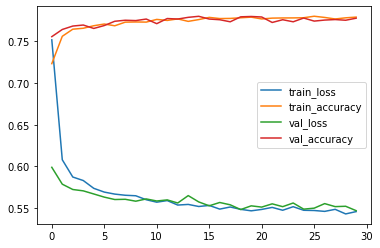

In [58]:
plt.plot(epochs, hist2['loss'], label = 'train_loss')
plt.plot(epochs, hist2['accuracy'], label = 'train_accuracy')
plt.plot(epochs, hist2['val_loss'], label = 'val_loss')
plt.plot(epochs, hist2['val_accuracy'], label = 'val_accuracy')
plt.legend()

In [60]:
# Evaluate the model on the test data using `evaluate`
test_ds = dataframe_to_dataset(test)
test_ds = test_ds.batch(10)

print("Evaluate on test data")
results2 = model2.evaluate(test_ds)
print("test loss, test accuracy:", results2)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
predictions2 = model2.predict(test_ds)
print("predictions shape:", predictions2.shape)

Evaluate on test data
271/271 [==============================] - 0s 552us/step - loss: 0.5400 - accuracy: 0.7872
test loss, test accuracy: [0.5399765968322754, 0.7872183322906494]
Generate predictions for test samples
predictions shape: (2707, 9)


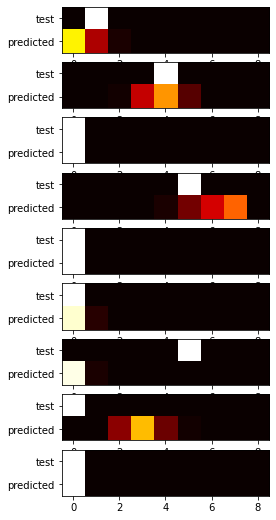

In [68]:
# Random predictions
nfig = 9
fig, ax = plt.subplots(nfig, figsize = [10,nfig])
for i in range(nfig):
    rand_i = np.random.randint(len(predictions2))
    lab = test['owners'].iloc[rand_i]
    lab_code = [0,0,0,0,0,0,0,0,0]
    lab_code[lab] = 1
    lab_code = np.array(lab_code).reshape(1,9)
    pred_code = predictions2[rand_i].flatten().reshape(1,9)
    twoline = np.concatenate((lab_code,pred_code))

    ax[i].imshow(twoline, cmap = 'hot')
    ax[i].set_yticks([0,1])
    ax[i].set_yticklabels(['test','predicted'])
    
#     plt.imshow(twoline, cmap = 'hot')
#     plt.yticks([0,1],['test','predicted'])
#     print( 'test_label:', lab_code)
#     print( 'predicted:',[f"{p:.2f}" for p in list(predictions[rand_i].flatten())])

# Conclusion
## 1. Regression model:
### test mean_squared_error: 0.0528 for 2707 test samples

## 2. Classification model:
### test loss: 0.5400 test accuracy: 0.7872